#### Notebook to make data for AmeriGeo 2021 presentation
by Cascade Tuholske

In [1]:
# Depedencies 
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import glob
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams
import os

In [2]:
# paths 
path = os.path.join('/home/cascade/cascade-scratch-forge/UEH-daily/stats')

In [3]:
glob.glob(path+'/*STATS.json')

['/home/cascade/cascade-scratch-forge/UEH-daily/stats/himax406_2d_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/himax461_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/himax406_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/wbgtmax28_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/wbgtmax32_STATS.json',
 '/home/cascade/cascade-scratch-forge/UEH-daily/stats/wbgtmax30_STATS.json']

## Regional Total

In [4]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [5]:
#### Load Data
DATA = 'wbgtmax30' # UPDATE 

# file paths
DATA_IN = '/scratch/cascade/UEH-daily/stats/'  
FIG_OUT = '/home/cascade/projects/UrbanHeat/figures/'
FN_IN = os.path.join(DATA_IN,DATA+'_EXP.json') # all, not p05 since this is global
HI_STATS = pd.read_json(FN_IN, orient = 'split')

# Set scale
scale = 10**6

# File out
FN_OUT = os.path.join(FIG_OUT,'AmeriGeo-Fig1-'+DATA+'-Final.tiff')

In [6]:
# Drop IDs where days 1983 = 1 with none else. throws error in regressions 

print(len(HI_STATS))
only83 = HI_STATS.groupby('ID_HDC_G0')['tot_days'].sum() == 1 # sum up total days and find those with 1 day
only83 = list(only83[only83 == True].index) # make a list of IDs
sub = HI_STATS[HI_STATS['ID_HDC_G0'].isin(only83)] # subset those IDs
bad_ids = sub[(sub['year'] == 1983) & (sub['tot_days'] == 1)] # drop those from 1983 only
drop_list = list(bad_ids['ID_HDC_G0']) # make a list
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)] # drop those from the list
print(len(HI_STATS))

303518
303178


In [7]:
#### Add In Meta Data (e.g. geographic data)
meta_fn = os.path.join('/home/cascade/projects/UrbanHeat/data/interim/','GHS-UCDB-IDS.csv')
meta_data = pd.read_csv(meta_fn)

#### Merge in meta
HI_STATS = HI_STATS.merge(meta_data, on = 'ID_HDC_G0', how = 'left')

In [8]:
# Subset for Ameri Geo countries
ameri_countries = ['Argentina', 'Bahamas', 'Belize', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
                  'Ecuador', 'El Salvador', 'Guatemala', 'Hondorus', 'Mexico', 'Panama', 'Paragua', 'Peru',
                  'United States', 'Uruguay']
ameri_stats = HI_STATS[HI_STATS['CTR_MN_NM'].isin(ameri_countries)]

In [9]:
np.unique(ameri_stats['CTR_MN_NM'])

array(['Argentina', 'Bahamas', 'Belize', 'Brazil', 'Canada', 'Colombia',
       'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Mexico',
       'Panama', 'Peru', 'United States', 'Uruguay'], dtype=object)

In [10]:
yr_range = max(HI_STATS['year']) - min(HI_STATS['year']) + 1

Text(2.5, 1.1, '(C)')

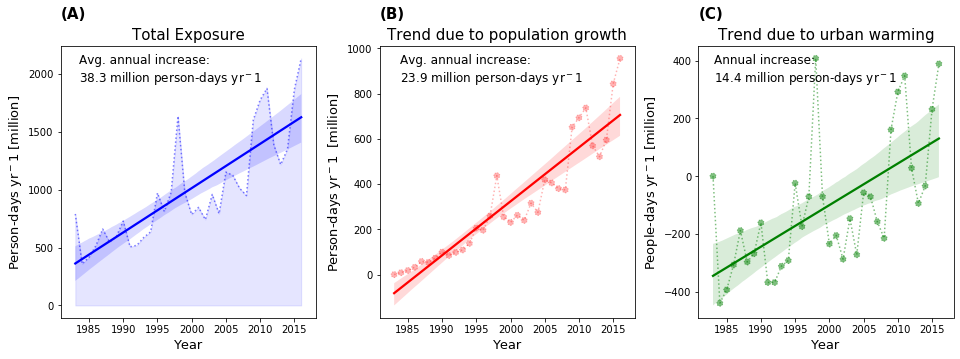

In [11]:
#### Make Figure & Save it

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

## Years to calc increase in pdays / yr 
## yr_range = max(ameri_stats['year']) - min(ameri_stats['year']) + 1

## PLOT 1 - People Days
color = 'blue'
data = ameri_stats.groupby('year')['people_days'].sum() / scale
years = list(data.index)
axs[0].plot(data, color = color, linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = color, alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = color, ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Total Exposure', size = 15 )
axs[0].set_ylabel('Person-days $yr^-1$ [million]', fontsize = 13)
axs[0].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(ameri_stats, 'people_days')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/scale, 1))+' million person-days $yr^-1$'
axs[0].text(0.07, .87, text, transform=axs[0].transAxes, size=12)
axs[0].text(0.00, 1.1, '(A)', transform=axs[0].transAxes, size=15, fontweight='bold')

## 2 PLOT 2 - People Days delta pop x days
color = 'red'
data = ameri_stats.groupby('year')['people_days_pop'].sum() / scale
axs[1].scatter(years, data, color = color, linestyle = ':', alpha = 0.3)
axs[1].plot(data, color = color, linestyle = ':', alpha = 0.3)
sns.regplot(years, data, color = color, ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Trend due to population growth', size = 15)
axs[1].set_ylabel('Person-days $yr^-1$  [million] ', fontsize = 13)
axs[1].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(ameri_stats, 'people_days_pop')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/scale, 1))+' million person-days $yr^-1$'
axs[1].text(1.25+.08, .87, text, transform=axs[0].transAxes, size=12)
axs[1].text(1.25, 1.1, '(B)', transform=axs[0].transAxes, size=15, fontweight='bold')

## PLOT 3 - People Days due to heat
color = 'green'
data = ameri_stats.groupby('year')['people_days_heat'].sum() / scale
pdays83 = data.get(data.index[0])
data = data - pdays83
years = list(data.index)
axs[2].scatter(years, data, color = color, linestyle = ':', alpha = 0.5)
axs[2].plot(data, color = color, linestyle = ':', alpha = 0.5)
sns.regplot(years, data, color = color, ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Trend due to urban warming', size = 15)
axs[2].set_xlabel('Year', fontsize = 13)
axs[2].set_ylabel('People-days $yr^-1$ [million]', fontsize = 13)

# Add text
coef, r2, p = lm_func(ameri_stats, 'people_days_heat')
text = 'Annual increase:\n'+str(round(coef/scale, 1))+' million person-days $yr^-1$'
axs[2].text(1.25*2-0.04+.1, .87, text, transform=axs[0].transAxes, size=12,);
axs[1].text(1.25*2, 1.1, '(C)', transform=axs[0].transAxes, size=15, fontweight='bold')

# save it out
#plt.savefig(FN_OUT, dpi = 300, bbox_inches='tight')

In [12]:
#### Total Change in people Days
data = ameri_stats.groupby('year')['people_days'].sum()
year = str(data.index[33])
value = str(data.values[33]/10**9)
print('person days in 2016 was '+value+' billion')

year = str(data.index[0])
value = str(data.values[0]/10**9)
print('person days in 1983 was '+value+' billion')

#### Pct Change in Poeple Days 1983 - 2016
pdays16 = data.iloc[len(data) -1]
pdays83 = data.iloc[0]
out = (data.iloc[len(data) -1] - data.iloc[0]) / data.iloc[0] * 100
print('pct increase in people days 83 - 16 is ', out)



person days in 2016 was 2.135558868678947 billion
person days in 1983 was 0.7905892454327937 billion
pct increase in people days 83 - 16 is  170.12242843119807


In [13]:
#### Pct Pday Annual Increase from Heat
coef_pdays, r2_pdays, p_pdays = lm_func(ameri_stats, 'people_days') # regress pdays
coef_heat, r2_heat, p_heat = lm_func(ameri_stats, 'people_days_heat') # regreas heat

print('warming is what pct of total?', coef_heat/coef_pdays *100)

warming is what pct of total? 37.65867901770164


In [14]:
#### Pct heat vs pop
coef_pop, r2_pdays, p_pdays = lm_func(ameri_stats, 'people_days_pop') # regress pdays
coef_heat, r2_heat, p_heat = lm_func(ameri_stats, 'people_days_heat') # regreas heat

print('pct of heat vs pop', coef_heat/coef_pop *100)

pct of heat vs pop 60.40725224349145


#### AmeriGeo Trends

In [15]:
#### Load Data
DATA_IN = "/scratch/cascade/UEH-daily/stats/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
data = 'wbgtmax30'
FN_IN = data+'_TREND_PDAYS05.json'
HI_STATS = pd.read_json(DATA_IN+FN_IN, orient = 'split')

In [16]:
# Subset
# Subset for Ameri Geo countries
ameri_countries = ['Argentina', 'Bahamas', 'Belize', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Costa Rica',
                  'Ecuador', 'El Salvador', 'Guatemala', 'Hondorus', 'Mexico', 'Panama', 'Paragua', 'Peru',
                  'United States', 'Uruguay']
ameri_stats = HI_STATS[HI_STATS['CTR_MN_NM'].isin(ameri_countries)]

In [17]:
ameri_ghs = meta_data[meta_data['CTR_MN_NM'].isin(ameri_countries)]

In [18]:
# save
#ameri_stats.to_json('/scratch/cascade/UEH-daily/stats/wbgtmax30_TREND_PDAYS05-AmeriGEO.json')

In [20]:
# stats
ans = 100 * len(ameri_stats)/len(ameri_ghs)
print('how many ameri-geo cities had sig increase', ans)
print('how many cities', len(ameri_stats))

how many ameri-geo cities had sig increase 16.550522648083625
how many cities 190


In [25]:
ans = ameri_stats['P2016'].sum()
print('how many people in 2016', ans/10**6)

how many people in 2016 56.64379278631744


In [31]:
ameri_stats.sort_values('coef_pdays', ascending = False).head(25)

,ID_HDC_G0,coef_pdays,p_value_pdays,coef_heat,p_value_heat,coef_pop,p_value_pop,coef_totDays,p_value_totDays,coef_attrib,CTR_MN_NM,UC_NM_MN,GCPNT_LAT,GCPNT_LON,region,sub-region,intermediate-region,P1983,P2016
109,315,2.733305e+06,0.0001,1.224545e+06,0.0025,1.508760e+06,0.0000,0.473797,0.0025,5.199115,United States,Houston [USA],29.781371,-95.408370,Americas,Northern America,Northern America,2.584536e+06,4.873720e+06
40,73,1.530568e+06,0.0000,5.029939e+05,0.0002,1.027574e+06,0.0000,1.224599,0.0002,17.136776,Mexico,Culiacan [MEX],24.796611,-107.407183,Americas,Latin America and the Caribbean,Central America,4.107417e+05,7.219748e+05
88,237,1.318394e+06,0.0000,2.305322e+05,0.0009,1.087862e+06,0.0000,0.889076,0.0009,32.514160,Mexico,Reynosa [MEX]; Hidalgo [USA],26.044415,-98.304131,Americas,Latin America and the Caribbean,Central America,2.592943e+05,6.779137e+05
73,221,1.238003e+06,0.0000,9.372972e+05,0.0000,3.007057e+05,0.0000,1.763484,0.0000,-25.710422,Mexico,Tampico [MEX],22.268675,-97.855240,Americas,Latin America and the Caribbean,Central America,5.315032e+05,6.224712e+05
34,65,1.197756e+06,0.0000,2.300714e+05,0.0076,9.676849e+05,0.0000,0.621849,0.0076,30.791470,Mexico,Hermosillo [MEX],29.085519,-110.974599,Americas,Latin America and the Caribbean,Central America,3.699796e+05,7.889490e+05
100,255,1.194660e+06,0.0000,2.567907e+05,0.0002,9.378695e+05,0.0000,1.351261,0.0002,28.505124,Mexico,Villahermosa [MEX],17.992885,-92.946537,Americas,Latin America and the Caribbean,Central America,1.900379e+05,5.111306e+05
45,79,1.114917e+06,0.0022,-1.991958e+05,0.3684,1.314113e+06,0.0000,-0.107563,0.3684,67.866417,United States,Phoenix-Mesa [USA],33.477560,-112.000537,Americas,Northern America,Northern America,1.851898e+06,3.611577e+06
530,1006,1.032342e+06,0.0027,3.035195e+05,0.1216,7.288225e+05,0.0000,0.365928,0.1216,20.598938,Brazil,Manaus [BRA],-3.063915,-59.993898,Americas,Latin America and the Caribbean,South America,8.294510e+05,2.016987e+06
300,622,1.019800e+06,0.0000,2.108154e+05,0.0277,8.089843e+05,0.0000,1.321161,0.0277,29.327761,Peru,Pucallpa [PER],-8.386972,-74.568247,Americas,Latin America and the Caribbean,South America,1.595683e+05,3.419190e+05
114,323,7.552700e+05,0.0441,3.157374e+05,0.1986,4.395326e+05,0.0014,0.104813,0.1986,8.195432,United States,Dallas-Fort Worth [USA],32.857349,-96.965262,Americas,Northern America,Northern America,3.012392e+06,5.165561e+06
